<a href="https://colab.research.google.com/github/monicafar147/regression-predict-api-template/blob/monique2/Wright.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   make sure you are working in your own branch that you cloned from git
*   to commit your notebook changes to git:
1.   file
2.   save a copy in github
3.   choose your branch from branches dropdown
4.   change commit message to what you did e.g. "fixed dataframe indexes"
5.   click ok

# Introduction to problem and dataset

## Importing the libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set(palette='pastel')

## Importing the datasets and splitting it into features and outputs

In [0]:
orders = pd.read_csv(r'Train.csv', parse_dates=['Pickup - Time', 'Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Arrival at Destination - Time'])
training_features = orders.iloc[:, :-1]
training_outputs = orders.iloc[:, -1]
test_features = pd.read_csv(r'Test.csv', parse_dates=['Pickup - Time', 'Placement - Time', 'Confirmation - Time'])

In [31]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Order No                                   21201 non-null  object        
 1   User Id                                    21201 non-null  object        
 2   Vehicle Type                               21201 non-null  object        
 3   Platform Type                              21201 non-null  int64         
 4   Personal or Business                       21201 non-null  object        
 5   Placement - Day of Month                   21201 non-null  int64         
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64         
 7   Placement - Time                           21201 non-null  datetime64[ns]
 8   Confirmation - Day of Month                21201 non-null  int64         
 9   Confirmation - We

In [32]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7068 entries, 0 to 7067
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Order No                              7068 non-null   object        
 1   User Id                               7068 non-null   object        
 2   Vehicle Type                          7068 non-null   object        
 3   Platform Type                         7068 non-null   int64         
 4   Personal or Business                  7068 non-null   object        
 5   Placement - Day of Month              7068 non-null   int64         
 6   Placement - Weekday (Mo = 1)          7068 non-null   int64         
 7   Placement - Time                      7068 non-null   datetime64[ns]
 8   Confirmation - Day of Month           7068 non-null   int64         
 9   Confirmation - Weekday (Mo = 1)       7068 non-null   int64         
 10  

In [33]:
training_outputs

0         745
1        1993
2         455
3        1341
4        1214
         ... 
21196       9
21197     770
21198    2953
21199    1380
21200    2128
Name: Time from Pickup to Arrival, Length: 21201, dtype: int64

At this stage, we notice that there are missing values from `Temperature` and `Precipitation in millimeters`. We also need to convert all the columns that contain time information from objects to a datetime format.

# Exploratory Data Analysis

To first get well-acquainted with the data, we will first explore any obvious relationships between variables.

In [34]:
training_features.describe()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long
count,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,16835.000000,552.000000,21201.000000,21201.000000,21201.000000,21201.000000
mean,2.752182,15.653696,3.240083,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,9.506533,23.258889,7.905797,-1.281470,36.811264,-1.282581,36.811220
std,0.625178,8.798916,1.567295,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,5.668963,3.615768,17.089971,0.030507,0.037473,0.034824,0.044721
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.200000,0.100000,-1.438302,36.653621,-1.430298,36.606594
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,20.600000,1.075000,-1.300921,36.784605,-1.301201,36.785661
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,23.500000,2.900000,-1.279395,36.807040,-1.284382,36.808002
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,26.000000,4.900000,-1.257147,36.829741,-1.261177,36.829477
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,49.000000,32.100000,99.100000,-1.147170,36.991046,-1.030225,37.016779


In [35]:
test_features.describe()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long
count,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,5631.000000,199.000000,7068.000000,7068.000000,7068.000000,7068.000000
mean,2.752122,15.621817,3.249859,15.621817,3.249859,15.621817,3.249859,15.621817,3.249859,9.458970,23.246120,6.651759,-1.282043,36.811148,-1.282255,36.811326
std,0.624000,8.776650,1.580926,8.776650,1.580926,8.776650,1.580926,8.776650,1.580926,5.575689,3.591161,14.085439,0.030044,0.037962,0.034236,0.043507
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.200000,0.100000,-1.433512,36.653828,-1.422652,36.639195
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,20.600000,1.100000,-1.301201,36.784605,-1.300921,36.786546
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,23.400000,2.900000,-1.281301,36.807219,-1.283219,36.807927
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,25.900000,4.950000,-1.257274,36.829716,-1.261256,36.828195
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,47.000000,32.100000,99.100000,-1.148352,36.991046,-1.030225,37.018958


In [36]:
training_outputs.describe()

count    21201.000000
mean      1556.920947
std        987.270788
min          1.000000
25%        882.000000
50%       1369.000000
75%       2040.000000
max       7883.000000
Name: Time from Pickup to Arrival, dtype: float64

## Creating ECDF Plots for Distances and Delivery Times

Text(0.5, 1.0, 'ECDF Plot for Delivery Time')

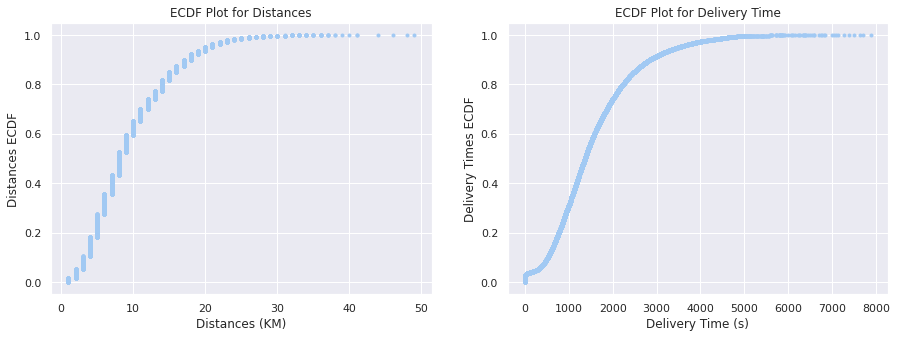

In [37]:
distances = np.sort(orders['Distance (KM)'])
distances_ecdf = np.arange(1, len(distances) + 1) / len(distances)
delivery_times = np.sort(orders['Time from Pickup to Arrival'])
delivery_times_ecdf = np.arange(1, len(delivery_times) + 1) / len(delivery_times)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(distances, distances_ecdf, marker='.', linestyle='none')
ax1.set_xlabel('Distances (KM)')
ax1.set_ylabel('Distances ECDF')
ax1.set_title('ECDF Plot for Distances')

ax2.plot(delivery_times, delivery_times_ecdf, marker='.', linestyle='none')
ax2.set_xlabel('Delivery Time (s)')
ax2.set_ylabel('Delivery Times ECDF')
ax2.set_title('ECDF Plot for Delivery Time')

We can see that 60 and 95 percent of deliveries are within 10KM and 20KM respectively.


With the time distributions we see that 60 and 95 percent of the delivery times are within approximately 1500(s) and 3000(s)

Based on the above distrubutions it would be interesting to build a simple Linear Regression model using only the Distance feature in our model.

## Exploring Day of Month columns

By just eyeing the first few rows of the data, it seems that the order might tend to be picked up on the same day that the order was placed. 

In [38]:
# Creating a column that calculates the difference between when the
# order was made and when the order was picked up
orders['placement_pickup'] = orders['Pickup - Day of Month'] - orders['Placement - Day of Month']
print(orders[orders['placement_pickup'] > 0])

# Dropping the calculated column
orders.drop(['placement_pickup'], axis=1, inplace=True)

           Order No  ... placement_pickup
4024  Order_No_2800  ...                1
9804  Order_No_3530  ...                2

[2 rows x 30 columns]


It seems that there have only been two cases when the order was made and picked up on different days (and the difference was only one or two days). Out of 21201 rows of data, this data seems that it will have minor predictive capabilities.

It can therefore be suggested that when training the model, we only include one Day of Week and Day of Month column because they will have high multicollinearity.

## Modifying data characteristics in thenorders data

In [0]:
orders[['Vehicle Type', 'Platform Type', 'Personal or Business']] = orders[['Vehicle Type', 'Platform Type', 'Personal or Business']].astype('category')
orders[['Placement - Day of Month', 'Placement - Weekday (Mo = 1)', 'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)']] = orders[['Placement - Day of Month', 'Placement - Weekday (Mo = 1)', 'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)']].astype('category')
orders[['Arrival at Pickup - Day of Month', 'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)']] = orders[['Arrival at Pickup - Day of Month', 'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)']].astype('category')

## Exploring distributions of data

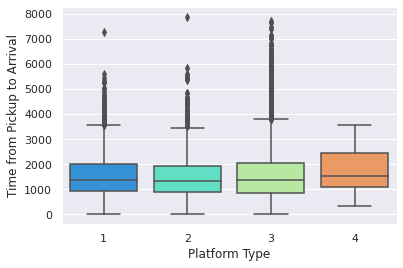

In [40]:
sns.boxplot(x='Platform Type', y='Time from Pickup to Arrival', data=orders, palette='rainbow')

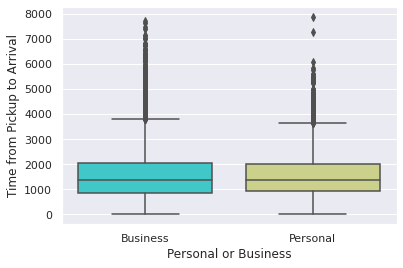

In [41]:
sns.boxplot(x='Personal or Business', y='Time from Pickup to Arrival', data=orders, palette='rainbow')

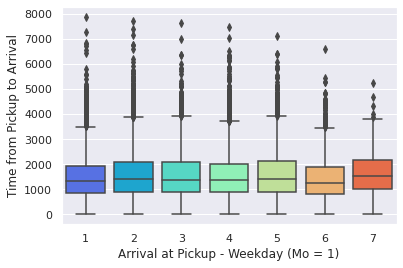

In [42]:
sns.boxplot(x='Arrival at Pickup - Weekday (Mo = 1)', y='Time from Pickup to Arrival', data=orders, palette='rainbow')

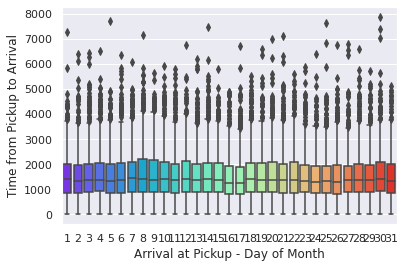

In [43]:
sns.boxplot(x='Arrival at Pickup - Day of Month', y='Time from Pickup to Arrival', data=orders, palette='rainbow')

These boxplots, which each represent several categoral features plotted against the delivery times, indicate that there doesn't seem to be a huge difference in travel time between the different groups in each category. There are quite a number of outliers in all of the groups in each of the categories?

A boxplot distribution of this shape indicates that there may be many points where `Time from Pickup to Arrival` is very low:


In [44]:
print('Time from pickup to arrival less than 60s:', len(orders[orders['Time from Pickup to Arrival'] < 60]))
print('Time from pickup to arrival of 1s: ', len(orders[orders['Time from Pickup to Arrival'] ==1]))

Time from pickup to arrival less than 60s: 740
Time from pickup to arrival of 1s:  37


`Time from pickup to arrival` of less than 60 seconds seems unrealistic, especially 1 second. It would be useful to look at the distances of these deliveries, because it is possible that riders may have forgotten to confirm the pickup on the app until they dropped off the parcel, resulting in this unrealistic time frame.

## Correlations

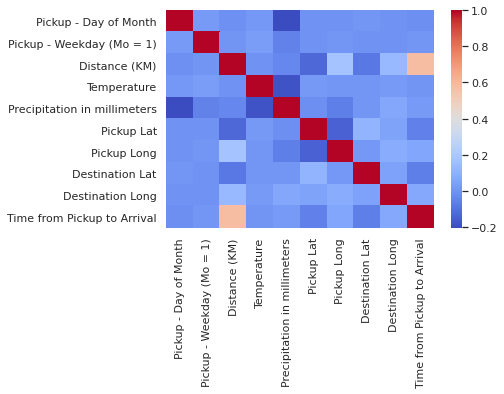

In [45]:
orders_corr = orders.corr()
sns.heatmap(orders_corr, cmap='coolwarm')

# Data Preprocessing

## Dealing with missing values

As described above, there are null-values present in the `Temperature` and `Precipitation in millimeters` columns.

We would be able to fill the missing `Temperature` values with values from the same dates where measurements were taken, but we don't know the actual date of each measurement. The easiest option would be to fill the missing values with the average of the column, but we should find a better way of doing this.

We are assuming that if `Precipitation in millimeters` is missing, that it was not raining on that day. We can therefore fill null values with 0.

In [0]:
# Fill missing precipitation values with 0
training_features['Precipitation in millimeters'] = training_features['Precipitation in millimeters'].fillna(value=0)

# Fill missing temperature values with averages
training_features['Temperature'] = training_features['Temperature'].fillna(training_features['Temperature'].mean())

##  Converting the following features into categories
1.   Pickup - Day of Month
2.   Pickup - Weekday (Mo = 1)
3.   Platform Type
4.   Personal or Business

In [0]:
training_features[['Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)']] = training_features[['Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)']].astype('category')
training_features[['Platform Type', 'Personal or Business']] = training_features[['Platform Type', 'Personal or Business']].astype('category')

##  Selecting the following features to be part of the training data
1.   Platform Type
2.   Personal or Business
3.   Pickup - Day of Month
4.   Pickup - Weekday (Mo = 1)
5.   Pickup - Time
6.   Distance (KM)
7.   Temperature
8.   Precipitation in millimeters

In [0]:
training_features = training_features[['Platform Type', 'Personal or Business', 'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time', 'Distance (KM)', 'Temperature', 'Precipitation in millimeters']]

####  Function for assigning the different Pickup Times to 6 distinct groups
1.   Early Morning
2.   Morning
3.   Late Morning
4.   Afternoon
5.   Late Afternoon
6.   Evening

In [0]:
def assign_time_category(delivery_time):
    dts = pd.DataFrame(['12:00:00 AM', '6:00:00 AM', '9:00:00 AM', '12:00:00 PM', '3:00:00 PM', '6:00:00 PM'])[0].astype('datetime64[ns]')
    if delivery_time >= dts[0] and delivery_time < dts[1]:
        return 'Early Morning'
    elif delivery_time >= dts[1] and delivery_time < dts[2]:
        return 'Morning'
    elif delivery_time >= dts[2]  and delivery_time < dts[3]:
        return 'Late Morning'
    elif delivery_time >= dts[3] and delivery_time < dts[4]:
        return 'Afternoon'
    elif delivery_time >= dts[4] and delivery_time < dts[5]:
        return 'Late Afternoon'
    else:
        return 'Evening'

## Adding new feature called "Delivery Times"
1.   This new feature is based on the "Pickup Time" feature
2.   Its created using the (assign_time_category) function
3.   Then is changed into a categorical feature

In [0]:
training_features['Delivery Times'] = training_features['Pickup - Time'].apply(assign_time_category)
training_features['Delivery Times'] = training_features['Delivery Times'].astype('category')

## Dropping the "Pickup Times" feature

In [0]:
training_features.drop('Pickup - Time', axis=1, inplace=True)

## Encoding data

### One-hot encoding for categorical data

In [0]:
training_features = pd.get_dummies(training_features,
                                   columns=['Platform Type', 'Personal or Business', 'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Delivery Times'],
                                   prefix=['platformtype', 'personalbusiness', 'dayofmonth', 'weekday', 'pickuptimes'])

# Model Building

In [0]:
from sklearn import metrics
import math

## Multiple Linear Regression Model

In [54]:
# Import LinearRegression module and create object
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()

# Fit a linear regression model
linear_model.fit(training_features, training_outputs)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
print("Training MSE:", metrics.mean_squared_error(training_outputs, linear_model.predict(training_features)))

Training MSE: 639920.1280760383


In [56]:
print("Training RMSE:", np.sqrt(metrics.mean_squared_error(training_outputs, linear_model.predict(training_features))))

Training RMSE: 799.9500784899258


## Regression Tree Model

In [57]:
from sklearn.tree import DecisionTreeRegressor
regression_tree = DecisionTreeRegressor(random_state = 0)
regression_tree.fit(training_features, training_outputs)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [58]:
print("Training MSE:", metrics.mean_squared_error(training_outputs, regression_tree.predict(training_features)))

Training MSE: 83011.49675032175


In [59]:
print("Training RMSE:", np.sqrt(metrics.mean_squared_error(training_outputs, regression_tree.predict(training_features))))

Training RMSE: 288.1171580283301


## Random Forest Model

In [60]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators = 7, random_state = 0)
random_forest.fit(training_features, training_outputs)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=7, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [61]:
print("Training MSE:", metrics.mean_squared_error(training_outputs, random_forest.predict(training_features)))

Training MSE: 207730.54555147304


In [62]:
print("Training RMSE:", np.sqrt(metrics.mean_squared_error(training_outputs, random_forest.predict(training_features))))

Training RMSE: 455.7746653242949


## Simple Linear Regression

The ECDF plots for Delivery Time and Distance are almost identical. For interest's sake, this model predicts delivery time based on distance (KM) only.

In [78]:
slr = LinearRegression()

slr_X = training_features['Distance (KM)']
slr_X = slr_X[:,np.newaxis]

slr.fit(slr_X, training_outputs)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [79]:
# Making a prediction for 12km
print(slr.predict([[12]]))

[1809.04790942]


In [80]:
print("Training RMSE:", np.sqrt(metrics.mean_squared_error(training_outputs, slr.predict(slr_X))))

Training RMSE: 803.800449277611
